In [2]:
!pip -q install biopython pandas matplotlib

In [3]:
# ------------------------------
# CREATE A FOLDER STRUCTURE
# ------------------------------

from pathlib import Path   

BASE = Path().resolve()    
DATA = BASE / "Codon-Usage Bias" / "data"       
RES  = BASE / "Codon-Usage Bias" / "results" / "codon_usage"   
FIGS = BASE / "Codon-Usage Bias" / "figures" / "codon_usage"   

for p in (DATA, RES, FIGS):               
    p.mkdir(parents=True, exist_ok=True) 
BASE, DATA, RES, FIGS                      


(PosixPath('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c'),
 PosixPath('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/data'),
 PosixPath('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/results/codon_usage'),
 PosixPath('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/figures/codon_usage'))

In [4]:
# ----------------------------------------------
# DOWNLOAD MULTI-FASTA (CDS) FOR TWO ORGANISMS
# ----------------------------------------------

import urllib.request  

mt_url = (
    "https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi"
    "?id=NC_012920.1&db=nuccore&report=fasta_cds_na"
)  # Human mitochondrion (rCRS) CDS
ec_url = (
    "https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi"
    "?id=NC_000913.3&db=nuccore&report=fasta_cds_na"
)  # E. coli K-12 MG1655 CDS

mt_cds_path = (DATA / "human_mtDNA_NC_012920.1_CDS.fasta").as_posix()  
ec_cds_path = (DATA / "Ecoli_MG1655_NC_000913.3_CDS.fasta").as_posix()

def fetch(url: str, out_path: str) -> None:
    urllib.request.urlretrieve(url, out_path) 

fetch(mt_url, mt_cds_path)
fetch(ec_url, ec_cds_path)

print("Downloaded:")
print(" -", mt_cds_path)
print(" -", ec_cds_path)


Downloaded:
 - /home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/data/human_mtDNA_NC_012920.1_CDS.fasta
 - /home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/data/Ecoli_MG1655_NC_000913.3_CDS.fasta


In [5]:
# -------------------------------------------------
# FASTA READER + CODON COUNTING / FREQUENCY TOOLS
# -------------------------------------------------

from typing import Iterator, Tuple, Dict 

def iter_fasta(path: str) -> Iterator[Tuple[str, str]]: 
    header = None          
    chunks = []            
    with open(path, "r", encoding="utf-8") as fh:   
            for line in fh:                              
            line = line.strip()                      
            if not line:                             
                continue
            if line.startswith(">"):                 
                if header is not None:              
                    yield header, "".join(chunks).upper().replace("U","T")  
                header = line[1:].strip()           
                chunks = []                         
            else:
                chunks.append(line.replace(" ", "")) 
        if header is not None:                       
            yield header, "".join(chunks).upper().replace("U","T")

def is_clean_codon(c: str) -> bool:
    return len(c) == 3 and all(b in "ACGT" for b in c)  

def count_codons_in_seq(seq: str) -> Dict[str, int]:
    counts: Dict[str, int] = {}
    n = len(seq) - (len(seq) % 3)      
    for i in range(0, n, 3):           
        codon = seq[i:i+3]             
        if is_clean_codon(codon):      
            counts[codon] = counts.get(codon, 0) + 1  
    return counts

def count_codons_in_fasta(path: str) -> Dict[str, int]:
    total: Dict[str, int] = {}
    for hdr, seq in iter_fasta(path):        
        c = count_codons_in_seq(seq)         
        for k, v in c.items():               
            total[k] = total.get(k, 0) + v
    return total

def counts_to_freqs(counts: Dict[str, int]) -> Dict[str, float]:
    total = sum(counts.values()) or 1        
    return {k: v/total for k, v in counts.items()}


In [6]:
# -----------------------------------------
# RUN COUNTS + SAVE COUNTS / FREQS AS CSVs
# -----------------------------------------

import csv  

mt_counts = count_codons_in_fasta(mt_cds_path)   
ec_counts = count_codons_in_fasta(ec_cds_path)

mt_freqs  = counts_to_freqs(mt_counts)           
ec_freqs  = counts_to_freqs(ec_counts)

def save_codon_table(d: Dict[str, float], out_path: Path, value_name: str):
    rows = [{"codon": k, value_name: d[k]} for k in sorted(d.keys())]  
    with open(out_path, "w", newline="", encoding="utf-8") as fh:
        w = csv.DictWriter(fh, fieldnames=["codon", value_name])
        w.writeheader()
        for r in rows:
            w.writerow(r)

save_codon_table(mt_counts, RES / "mt_counts.csv", "count")
save_codon_table(ec_counts, RES / "ec_counts.csv", "count")
save_codon_table(mt_freqs,  RES / "mt_freqs.csv",  "freq")
save_codon_table(ec_freqs,  RES / "ec_freqs.csv",  "freq")

(RES / "mt_freqs.csv").as_posix(), (RES / "ec_freqs.csv").as_posix()   

('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/results/codon_usage/mt_freqs.csv',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/results/codon_usage/ec_freqs.csv')

('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/figures/codon_usage/mt_top_codons.png',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/figures/codon_usage/ec_top_codons.png',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/Codon-Usage Bias/figures/codon_usage/compare_scatter.png')

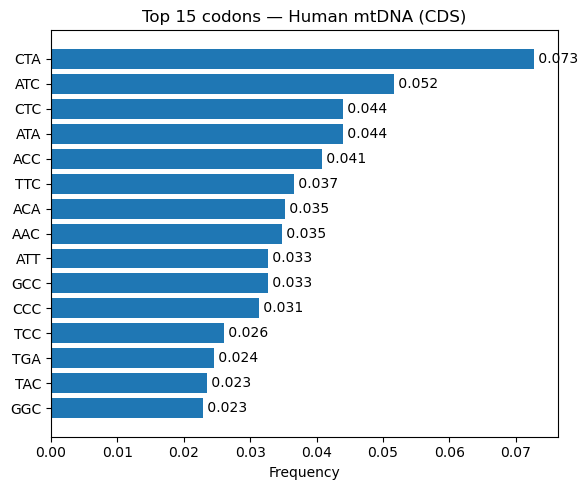

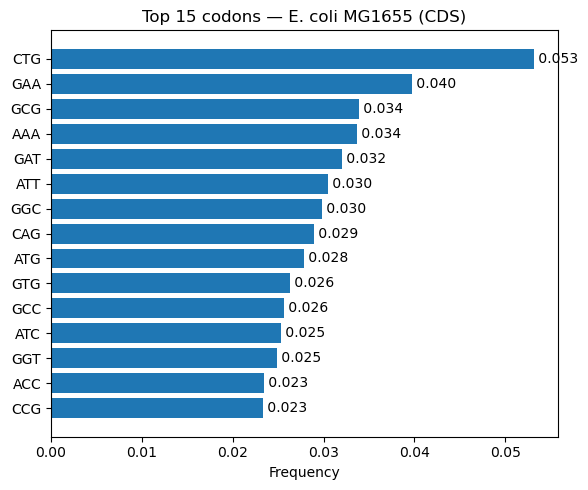

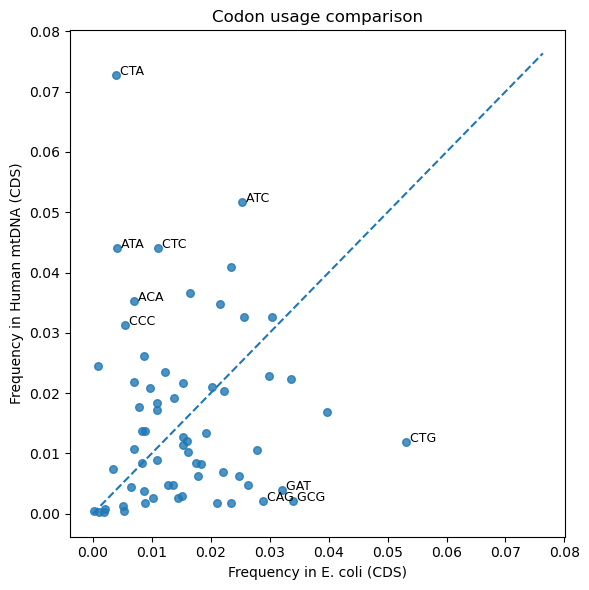

In [7]:
# --------------------------
# HIGH-QUALITY VISUALIZATIONS
# --------------------------

import pandas as pd                  
import numpy as np                   
import matplotlib.pyplot as plt      

mt_df = pd.DataFrame([{"codon": k, "freq": v} for k, v in mt_freqs.items()])
ec_df = pd.DataFrame([{"codon": k, "freq": v} for k, v in ec_freqs.items()])

# --- Plot A: Top 15 codons by frequency (each organism separately) ---
def plot_top_codons(df: pd.DataFrame, org_label: str, out_path: Path, top_n: int = 15):
    top = df.sort_values("freq", ascending=False).head(top_n)
    plt.figure(figsize=(6, 5))                    
    plt.barh(top["codon"], top["freq"])           
    plt.gca().invert_yaxis()                      
    plt.xlabel("Frequency")                       
    plt.title(f"Top {top_n} codons — {org_label}")  
    for i, (codon, freq) in enumerate(zip(top["codon"], top["freq"])):
        plt.text(freq, i, f" {freq:.3f}", va="center")   
    plt.tight_layout()                           
    plt.savefig(out_path.as_posix(), dpi=200, bbox_inches="tight")

plot_top_codons(mt_df, "Human mtDNA (CDS)", FIGS / "mt_top_codons.png")
plot_top_codons(ec_df, "E. coli MG1655 (CDS)", FIGS / "ec_top_codons.png")

# --- Plot B: Scatter comparing frequencies (E. coli vs Human mtDNA) ---
joined = pd.merge(ec_df, mt_df, on="codon", how="outer", suffixes=("_ecoli", "_mt")).fillna(0.0)

def plot_compare_scatter(df: pd.DataFrame, out_path: Path):
    x = df["freq_ecoli"].to_numpy()
    y = df["freq_mt"].to_numpy()
    plt.figure(figsize=(6,6))                   
    plt.scatter(x, y, s=30, alpha=0.8)          
    lim = max(x.max(), y.max()) * 1.05
    plt.plot([0, lim], [0, lim], linestyle="--") 
    diffs = np.abs(x - y)
    idx = diffs.argsort()[::-1][:10]           
    for i in idx:
        codon = df["codon"].iloc[i]
        plt.text(x[i], y[i], f" {codon}", fontsize=9)
    plt.xlabel("Frequency in E. coli (CDS)")
    plt.ylabel("Frequency in Human mtDNA (CDS)")
    plt.title("Codon usage comparison")
    plt.tight_layout()
    plt.savefig(out_path.as_posix(), dpi=200, bbox_inches="tight")

plot_compare_scatter(joined, FIGS / "compare_scatter.png")

(FIGS / "mt_top_codons.png").as_posix(), (FIGS / "ec_top_codons.png").as_posix(), (FIGS / "compare_scatter.png").as_posix()


In [8]:
# -------------------------------------------
# OPTIONAL: MAP CODONS -> AMINO ACIDS (AA)
# -------------------------------------------

from Bio.Data import CodonTable   

aa_map_mt = CodonTable.unambiguous_dna_by_id[2].forward_table     
aa_map_ec = CodonTable.unambiguous_dna_by_id[11].forward_table    

# Example: add AA columns to the DataFrames 
mt_df["AA_mt"] = mt_df["codon"].map(lambda c: aa_map_mt.get(c, "STOP"))
ec_df["AA_ec"] = ec_df["codon"].map(lambda c: aa_map_ec.get(c, "STOP"))

mt_df.head(), ec_df.head()  # quick peek


(  codon      freq AA_mt
 0   ATA  0.043994     M
 1   CCC  0.031349     P
 2   ATG  0.010537     M
 3   GCC  0.032666     A
 4   AAC  0.034773     N,
   codon      freq AA_ec
 0   ATG  0.027863     M
 1   AAA  0.033677     K
 2   CGC  0.022091     R
 3   ATT  0.030481     I
 4   AGC  0.016082     S)